# Structural similarity

In [19]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

In [20]:
# function for Tanimoto similarity explicitly
def tanimoto_similarity(v1, v2):
    set_bits = 0
    shared_bits = 0
    for bitv1, bitv2 in zip(v1, v2):
        if bitv1 or bitv2: # if either bit is set
            set_bits += 1
        if bitv1 and bitv2: # if both bits are set
            shared_bits += 1
    return shared_bits / set_bits

# check implementation
print(tanimoto_similarity([1, 1, 0, 0], [0, 0, 1, 1])) # share nothing
print(tanimoto_similarity([0, 1, 1, 0], [1, 0, 1, 0])) # share bit of 3
print(tanimoto_similarity([1, 1, 1, 1], [0, 0, 1, 1])) # share 2 bits of 4
print(tanimoto_similarity([1, 1, 1, 1], [0, 1, 1, 1])) # share 3 bits of 4
print(tanimoto_similarity([1, 1, 0, 0], [1, 1, 0, 0])) # share 2 bits of 2


0.0
0.3333333333333333
0.5
0.75
1.0


In [21]:
# load dataset 

with open("../data/chembl_drd3_ic50.csv", 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    drd3_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier("../data/drugbank.sdf")
drugs = [m for m in suppl if m]

[15:21:40] Explicit valence for atom # 7 N, 4, is greater than permitted
[15:21:40] ERROR: Could not sanitize molecule ending on line 20009
[15:21:40] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[15:21:40] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[15:21:40] ERROR: Could not sanitize molecule ending on line 250947
[15:21:40] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[15:21:40] Explicit valence for atom # 17 O, 3, is greater than permitted
[15:21:40] ERROR: Could not sanitize molecule ending on line 258130
[15:21:40] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[15:21:40] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[15:21:40] ERROR: Could not sanitize molecule ending on line 261581
[15:21:40] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[15:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 6 7 8 9 10 11 12 13 14 15 16 17
[15:21:40] ERROR: Coul

In [22]:
from rdkit.Chem import MACCSkeys
fp1 = MACCSkeys.GenMACCSKeys(drugs[420])
fp2 = MACCSkeys.GenMACCSKeys(drugs[696])
print(fp1.ToBitString())
print(fp2.ToBitString())

00000000100100000000000010000000001010000000010100100100000000000100010100001111110111001101101111110110011000100000010111111001000101011101101100101011011011110111110
00000000000000000000000000000000000000000000000000000000000000000000000000010000100001100000100000101000000000110010011001100100110011010110001001011000011110101111110


In [23]:
tanimoto_similarity(fp1, fp2)

0.26506024096385544

In [24]:
from rdkit import DataStructs
DataStructs.TanimotoSimilarity(fp1, fp2) # same as tanimoto_similarity

0.26506024096385544

In [25]:
# calculate MACCS keys for all drugs and ligands. Then we do basic similarity search

drd3_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drd3_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]


Create a basic similarity search function. Take single binary vector as a query, compare it to all binary vectors in the provided searched set. If the Tanimoto similarity of the query vector to any of the searched fingerprints reaches or exceed our set cutoff value(0.8 is usually where some noticeable similarity starts to happen when using standard ECFP types), the index of the found similar vector is appended to the results. 

In [26]:
def similarity_search(query_fp, searched_fp_set, cutoff = 0.8):
    # we have no index, so we have to search all
    hits = []
    for i, fp in enumerate(searched_fp_set):
        sim = DataStructs.TanimotoSimilarity(query_fp, fp)
        if sim >= cutoff: # we have a hit
            hits.append((i, sim))
    return sorted(hits, key=lambda x: x[1], reverse=True) # strongest first
    

This is, in a very simplified fashon, exactly what the large, often commercial chemical databases do when users perform a similarity search. Their input structure gets fingerprinted, the resulting fingerprint compared to those in the database, and molecules with similar fingerprints are returned as hits. Of course, they do extended indexing and heuristics to make the searches quicker, alongside some hit reordering and sanitation, but the core principle is the same: create query fingerprint, compare with database fingerprints using some similarity metric, return hits above threshold. Same sh.t, different toilet :)

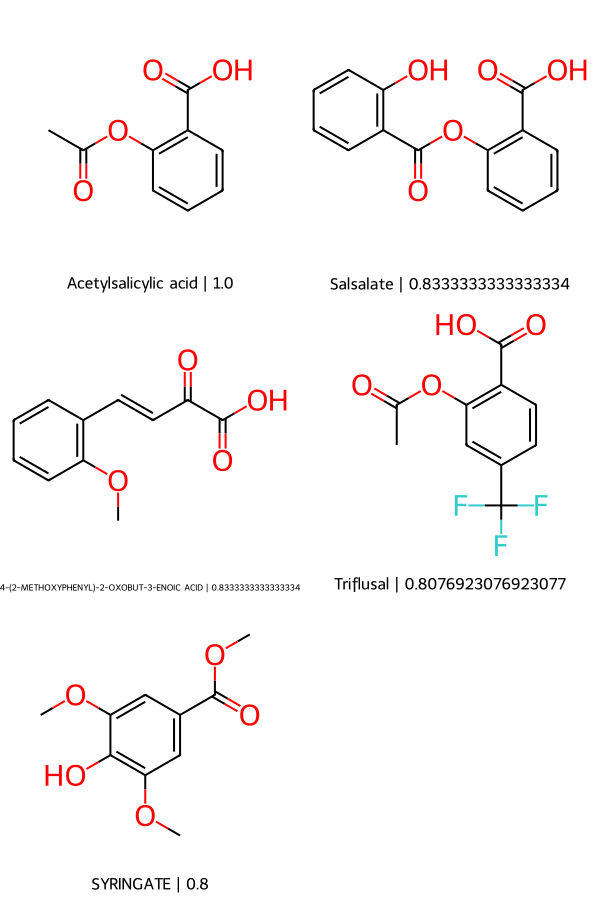

In [27]:
# let's use similarity search method to find aspirin in our drug set
aspirin = Chem.MolFromSmiles("O=C(C)Oc1ccccc1C(=O)O")
aspirin_fp = MACCSkeys.GenMACCSKeys(aspirin)
hits = similarity_search(aspirin_fp, drugs_maccs)
Draw.MolsToGridImage([drugs[h[0]] for h in hits],
                     molsPerRow=2, subImgSize=(300, 300),
                     legends=["{} | {}".format(drugs[hit[0]].GetProp("GENERIC_NAME"), hit[1]) for hit in hits])


In [40]:
# try to look up some molecule from ligands set within DrugBank

hits = similarity_search(drd3_ligands_maccs[444], drugs_maccs)
hits

[(71, 1.0),
 (476, 1.0),
 (728, 0.9629629629629629),
 (925, 0.9433962264150944),
 (6737, 0.9245283018867925),
 (178, 0.8909090909090909),
 (4681, 0.8909090909090909),
 (1133, 0.8888888888888888),
 (6735, 0.8653846153846154),
 (6832, 0.8653846153846154),
 (1098, 0.8545454545454545),
 (114, 0.8518518518518519),
 (548, 0.8518518518518519),
 (1205, 0.8518518518518519),
 (721, 0.8490566037735849),
 (432, 0.8333333333333334),
 (330, 0.8214285714285714),
 (1109, 0.8214285714285714),
 (1223, 0.8214285714285714),
 (130, 0.8181818181818182),
 (6685, 0.8070175438596491),
 (572, 0.8035714285714286),
 (4677, 0.8035714285714286)]

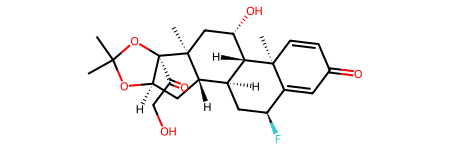

In [42]:
drd3_ligands[444] # my query structure

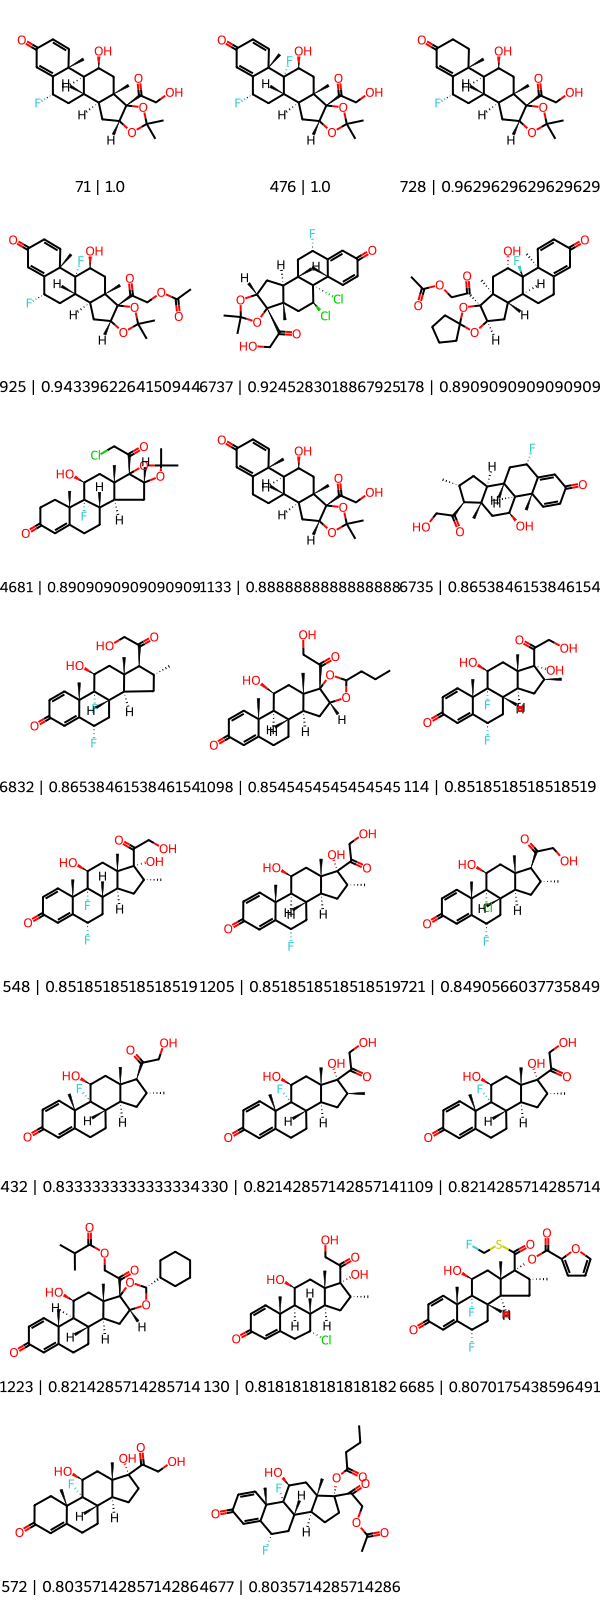

In [43]:
# the hit among drugbank using MACCS keys
Draw.MolsToGridImage([drugs[h[0]] for h in hits],
                        legends=["{} | {}".format(hit[0], hit[1]) for hit in hits])

In [44]:
# do exact query, using ECFP

drd3_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                        for m in drd3_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                        for m in drugs]

In [45]:
hits = similarity_search(drd3_ligands_ecfp[444], drugs_ecfp)
hits

[(71, 1.0)]

In [46]:
# ECFP based similarity
DataStructs.TanimotoSimilarity(drd3_ligands_ecfp[444], drugs_ecfp[925])

0.5256410256410257

In [47]:
DataStructs.TanimotoSimilarity(drd3_ligands_ecfp[444], drugs_ecfp[6737])

0.6197183098591549